# Ordinal model

This messy notebook trains the XGboost model used in wikidit.

In [320]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import wikidit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [321]:
from wikidit.preprocessing import _load_backlog, WP10_LABELS
from wikidit.io import read_labeled
from wikidit.ordinal import SequentialClassifier

# Train Model

In [322]:
import dill

In [323]:
import os
import os.path
import gzip
import json
import pandas as pd
from joblib import Parallel, delayed

In [324]:
output_dir = "../data/enwiki-labeling_revisions-w_features/"
revisions = read_labeled(output_dir)

In [325]:
from sklearn.model_selection import train_test_split

In [326]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
import dill
import itertools

from sklearn.preprocessing import FunctionTransformer, Binarizer

count_cols = ['words',
             # infobox as a binary
             'backlog_accuracy',
             'backlog_content',
             'backlog_other',
             'backlog_style',
             'backlog_links']

per_word_cols = [
             'headings_per_word',
             'sub_headings_per_word',
             # links
             'images_per_word',
             'categories_per_word',
             'wikilinks_per_word',
             'external_links_per_word',
             # templates
             'main_templates_per_word',
             'cite_templates_per_word',
             'ref_per_word'    
]

binarized_cols = ['coordinates', 'infoboxes']

response_col = ['wp10']

def create_features(df):
    df = df.copy()
    for c in count_cols:
        df[c] = np.sqrt(df[c])
    for c in binarized_cols:
        df[c] = df[c].astype(bool)
    allcols = list(itertools.chain(per_word_cols, count_cols, binarized_cols))
    return df.loc[:, allcols]

mapper = DataFrameMapper([
    (count_cols, FunctionTransformer(func=np.sqrt, validate=False)),
    (binarized_cols, Binarizer()),
    (per_word_cols, None)
])

X = revisions
y = revisions['wp10'].values

In [492]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, log_loss, 
                             confusion_matrix)
from sklearn.base import clone

In [596]:
xgb_params = {
  'silent': True,
  'booster': 'gbtree',
  'objective': 'binary:logistic',
  'random_state': 12345,
  'learning_rate': 0.1,
  'n_estimators': 200,
  'min_child_weight': 1,
  'gamma': 0,
  'subsample': 0.9,
  'colsample_bytree': 0.9,
  'max_depth': 6
}
# xgb_param_grid = {
#    'min_child_weight': list(range(1, 11)),
#    'gamma': [0.5, 1, 1.5, 2, 5],
#    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#    'max_depth': [2, 3, 4, 5, 6, 7, 8]
# }

clf = SequentialClassifier(xgb.XGBClassifier(**xgb_params))
pipeline = Pipeline([('mapper', mapper), ('clf', clf)])

In [597]:
fitted = clone(pipeline).fit(revisions, y)

In [598]:
with open("../models/xgboost-sequential.pkl", "wb") as f:
    dill.dump(fitted, f)

# Example 

In [599]:
from wikidit.preprocessing import Featurizer
from wikidit.mw import get_page, Session
featurizer = Featurizer()
session = Session()
page = get_page(session, 'Correlation')
revision = featurizer.parse_content(page['content'])
del revision['text']
revision = pd.DataFrame.from_records([revision])

In [600]:
from wikidit.models import predict_page_edits
results = predict_page_edits(featurizer, page['content'], fitted)


In [601]:
# from sklearn.preprocessing import PolynomialFeatures
#from sklearn.feature_selection import VarianceThreshold
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.decomposition import PCA
#pipeline = Pipeline([('mapper', mapper), 
#                     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#                     ('var', VarianceThreshold()),
#                     ('PCA', PCA(whiten=True, n_components=30)),
#                     ('clf', SequentialClassifier(LogisticRegressionCV(cv=5, max_iter=200)))])

In [602]:
#[{'description': x[1], 'value': round(x[2] * 100)} 
#                     for x in results['top_edits']]

https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Statistics

## FA

- Confirmation bias: https://en.wikipedia.org/wiki/Talk:Confirmation_bias
- https://en.wikipedia.org/wiki/Binary_search_algorithm

## GA

- https://en.wikipedia.org/wiki/Talk:Algorithmic_bias

## B

- https://en.wikipedia.org/wiki/Talk:Mean
- https://en.wikipedia.org/wiki/Talk:Student%27s_t-distribution

## C

- https://en.wikipedia.org/wiki/Talk:Pareto_efficiency
- https://en.wikipedia.org/wiki/Talk:Bootstrapping_(statistics)

## Start

- https://en.wikipedia.org/wiki/Talk:Bootstrap_aggregating

## Stub

- https://en.wikipedia.org/wiki/Talk:Correlation_coefficient


# Cross validation

In [603]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
predictions = []
for train_idx, test_idx in skf.split(X, y):
    X_train = revisions.iloc[train_idx, :]
    y_train = y[train_idx]
    X_test = revisions.iloc[test_idx, :]
    y_test = y[test_idx]
    cv_fit = pipeline.fit(X_train, y_train)
    y_pred = cv_fit.predict(X_test)
    predictions.append(pd.DataFrame({'actual': y_test, 'pred': y_pred}))

predictions = pd.concat(predictions)


To account for the accuracy, average the number of correct binary classifications each observation, then average over all observations.

In [604]:
n_classes = len(predictions['actual'].cat.categories)
np.mean(1 - np.abs(predictions['actual'].cat.codes - predictions['pred'].cat.codes) / (n_classes - 1))

0.8989452257586973

In [605]:
confusion = predictions.groupby(['actual', 'pred']).aggregate(len).reset_index()
confusion = confusion.rename(columns={0: 'n'})
confusion['p'] = confusion['n'] / confusion['n'].sum()
actual_totals = confusion.groupby(['actual'])['n'].transform('sum')
confusion['p_actual'] = confusion['n'] / actual_totals

In [606]:
confusion_table = confusion.pivot(index='actual', columns='pred', values='p_actual').fillna(0)

In [607]:
import seaborn as sns
import matplotlib.pyplot as plt

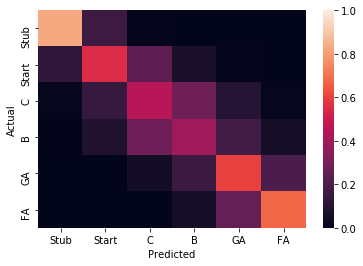

In [608]:
sns.heatmap(confusion_table, vmin=0, vmax=1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion-matrix.png')
plt.show()

# Tree of the Ordinal Model

In [609]:
from graphviz import Digraph

In [610]:
dot = Digraph(format='png')
dot.node('root', '')
dot.node('stub', 'P(Stub)')
dot.node('gtstub', 'P(x > Stub')
dot.node('start', 'P(Start)')
dot.node('gtstart', 'P(x > Start)')
dot.node('c', 'P(C)')
dot.node('gtc', 'P(x > C)')
dot.node('b', 'P(B)')
dot.node('gtb', 'P(x > B)')
dot.node('ga', 'P(GA)')
dot.node('fa', 'P(FA)')
dot.edges([['root', 'stub'], 
           ['root', 'gtstub'],
           ['gtstub', 'start'],
           ['gtstub', 'gtstart'],
           ['gtstart', 'c'],
           ['gtstart', 'gtc'],
           ['gtc', 'b'],
           ['gtc', 'gtb'],
           ['gtb', 'ga'],
           ['gtb', 'fa']            
          ])
print(dot.source)

digraph {
	root [label=""]
	stub [label="P(Stub)"]
	gtstub [label="P(x > Stub"]
	start [label="P(Start)"]
	gtstart [label="P(x > Start)"]
	c [label="P(C)"]
	gtc [label="P(x > C)"]
	b [label="P(B)"]
	gtb [label="P(x > B)"]
	ga [label="P(GA)"]
	fa [label="P(FA)"]
	root -> stub
	root -> gtstub
	gtstub -> start
	gtstub -> gtstart
	gtstart -> c
	gtstart -> gtc
	gtc -> b
	gtc -> gtb
	gtb -> ga
	gtb -> fa
}


In [557]:
dot.render('model.gv', view=True)

'model.gv.png'

# Parameter Tuning

In [516]:
from sklearn.model_selection import ParameterSampler

xgb_param_grid = {
    'clf__estimator__min_child_weight': list(range(1, 11)),
    'clf__estimator__gamma': [0.5, 1, 1.5, 2, 5],
    'clf__estimator__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__estimator__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__estimator__max_depth': [2, 3, 4, 5, 6, 7, 8]
}

In [517]:
list(ParameterSampler(xgb_param_grid, 5))

[{'clf__estimator__subsample': 0.8,
  'clf__estimator__min_child_weight': 2,
  'clf__estimator__max_depth': 6,
  'clf__estimator__gamma': 1,
  'clf__estimator__colsample_bytree': 0.7},
 {'clf__estimator__subsample': 0.7,
  'clf__estimator__min_child_weight': 4,
  'clf__estimator__max_depth': 8,
  'clf__estimator__gamma': 1.5,
  'clf__estimator__colsample_bytree': 1.0},
 {'clf__estimator__subsample': 0.8,
  'clf__estimator__min_child_weight': 5,
  'clf__estimator__max_depth': 6,
  'clf__estimator__gamma': 5,
  'clf__estimator__colsample_bytree': 0.5},
 {'clf__estimator__subsample': 0.5,
  'clf__estimator__min_child_weight': 6,
  'clf__estimator__max_depth': 2,
  'clf__estimator__gamma': 2,
  'clf__estimator__colsample_bytree': 0.6},
 {'clf__estimator__subsample': 1.0,
  'clf__estimator__min_child_weight': 5,
  'clf__estimator__max_depth': 2,
  'clf__estimator__gamma': 1,
  'clf__estimator__colsample_bytree': 1.0}]

In [518]:
#X = create_features(revisions)

rnd_search_pars = {'n_iter': 2, 'n_jobs': 3, 'cv': 2}

rnd_search = RandomizedSearchCV(pipeline, xgb_param_grid, scoring='neg_log_loss',
                                random_state=1234, refit=True,
                                **rnd_search_pars)
rnd_search.fit(revisions, y)

TypeError: take_nd() got an unexpected keyword argument 'axis'

In [ ]:
y_pred = pipeline.predict(X_test)
prob_pred = pipeline.predict_proba(X_test)

In [ ]:
scores[cat] = {
    'f1': f1_score(y_test, y_pred),
    'recall_score': recall_score(y_test, y_pred),
    'precision_score': precision_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred),
    'roc_auc_score': roc_auc_score(y_test, y_pred),
    'log_loss': log_loss(y_test, prob_pred)
}

After finding best parameter values for all models, refit using the entire sample.

# Feature Importances

In [510]:
import matplotlib.pyplot as plt
for cat, model in model.named_steps['clf'].named_estimators_.items():
    xgb.plot_importance(model)
    plt.title(f"Feature importance for {cat}")
    plt.show()

ValueError: tree must be Booster, XGBModel or dict instance

In [511]:
model

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=200,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)